In [25]:
%config InlineBackend.figure_format = 'retina' # For mac users with Retina display
import numpy as np
import matplotlib as mtlp
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import yaml
import pymc3 as pm
import math
import arviz as az
import theano
import theano.tensor as tensor
import pandas as pd
from matplotlib import rc
from scipy import optimize
import corner as crn
import seaborn as sns
import pickle 
from matplotlib.ticker import AutoMinorLocator
import matplotlib.patches as mpl_patches
import pygtc
######
import sys
sys.path.append('../HelpherFunctions/')
from Chi2Allvar import *
######
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
plt.rcParams['text.latex.preamble'] = r"\newcommand{\cqu}{C_{Qt}}"
plt.rcParams['text.latex.preamble'] = r"\newcommand{\cquqd}{C_{QtQb}}"

filename ="../results/data.yaml"
########
stream = open(filename, 'r')#
data = yaml.safe_load(stream)
#
colpastil = ['#9cadce','#937eba','#f09494','#72bbd0','#52b2cf','#ffafcc','#d3ab9e' ]
NBINS = 100
LambdaNP2 = 1e+3**2
v4 = 246.**4
v3 = 246.**3
mh2 = 125.1**2
sqrt_2 = np.sqrt(2.0)
## ***************************************************************************
## * RC param                                                                 *
## ***************************************************************************
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['font.family'] = 'serf'
## ***************************************************************************

In [10]:

def mode(x):
    """ Finds the mode of x
        argument:
            x: an array
    """
    n, bins = np.histogram(x, bins=101)
    m = np.argmax(n)
    m = (bins[m] + bins[m-1])/2.
    return m

def multimode(x, n, hdi_prob):
    """ Finds all the modes in the distribution
        arguments:
            x: the array for the distribution
            n: the identifier for the variable
    """
    md = az.hdi(x, hdi_prob=hdi_prob, multimodal=False)
    if len(md) < 2 and n > 1:
        return np.NaN
    else:
        return md[n%2]
    
def mode(x):
    # Function to find mode of an array x
    n, bins = np.histogram(x, bins=101)
    m = np.argmax(n)
    m = (bins[m] + bins[m-1])/2.
    return m

def minimize(likelihood, guess):
    """ Minimizing routine for finding global mode
    argument:
        likelihood: the likelihood function
        guess: the guess for the mode, [r, theta]
    """
    res = optimize.minimize(lambda x: -likelihood(x[0], x[1]), guess, method='BFGS', tol=1e-6)
    return res
unity = lambda x : x
stats_func_2 = {
        'b0': lambda x: multimode(x, 0, 0.9545),
        'b1': lambda x: multimode(x, 1, 0.9545),
        }
stats_func_1 = {
        'b0': lambda x: multimode(x, 0, 0.6827),
        'b1': lambda x: multimode(x, 1, 0.6827),
        }

In [4]:
def runMCMC(likelihood, limits, trace_dir='', config=[], fit=True):
    """ pyMC3 MCMC run
        argument:
            likelihood: the likelihood function
            limits: an array of the limits for the parameters [r_lowers, r_upper, theta_lower, theta_upper]
            trace_dir: the directory to which the MCMC traces are saves. '' implies none
            config: the setup for the MCMC. [MCMC smaple size, target_accept, chains]
            fit: bolean for determining whether to run the fit
        returns:
            trace: if fit is true it returns the trace
            model;if fit is false it returns the model
    """
    with pm.Model() as model:
        k1 = pm.Uniform('k1', lower=limits[0], upper=limits[1])
        k2 = pm.Uniform('k2', lower=limits[2], upper=limits[3])
        k3 = pm.Uniform('k3', lower=limits[4], upper=limits[5])
        k4 = pm.Uniform('k4', lower=limits[6], upper=limits[7])

        like = pm.Potential('like', likelihood(k1, k2, k3, k4))
        
    if fit:
        with model:
       #     theano.config.compute_test_value = "off"
            trace = pm.sample(config[0], tune=int(np.max([1000,config[0]/5])), cores=4, target_accept=config[1], chains=config[2], init='advi_map')
#             print(az.summary(trace, round_to=5)) # Turn on to print summary
       #     theano.config.compute_test_value = "off"
           # if trace_dir != '': pm.save_trace(trace=trace, directory=trace_dir, overwrite=True)
            with open(trace_dir, 'wb') as buff:
                pickle.dump({'model': model, 'trace': trace}, buff)
        return trace, model
    return model

 

In [ ]:
## 
NBINS = 50
CF=4/3
Nc=3
var=[r'$C_{Qt}^{+}$',r'$C_{Qt}^{-}$',r'$C_{QtQb}^{+}$',r'$C_\phi$']
##
llCqtm =lambda Cqup,Cqum,Cquqbp,CH :mylikelihoodAV(1/2*(Cqup+Cqum),1/2/CF*(Cqup-Cqum),
                                                   1/2/(2*Nc+1)*Cquqbp,+1/CF*Cquqbp/2,CH,data,experiments=['CMS','ATLAS'],
                                                                           HiggsChannels=['ggf','vbf','ttxh','vh','zh','wh']
                                                                           ,TopChannels=None, linearl3=True,linearmu=True)
limits = [-50, 20.5,-20.5,50.5,-6.5,6.5, -40, 40]
config = [150000, 0.8, 50]
trace_dir='../results/fits/4paramfit_l3_R.pickle'
trace_1, model_1 = runMCMC(llCqtm, limits, config=config,trace_dir=trace_dir)
with open(trace_dir, 'rb') as buff:
        data1 = pickle.load(buff)
        model = data1['model']
        trace_1 = data1['trace']
tr1 =np.array([trace_1.get_values('k1', burn=100, combine=True)]).flatten().T
tr2 =np.array([trace_1.get_values('k2', burn=100, combine=True)]).flatten().T
tr3 =np.array([trace_1.get_values('k3', burn=100, combine=True)]).flatten().T
tr4 =np.array([trace_1.get_values('k4', burn=100, combine=True)]).flatten().T
samples = np.array([tr1,tr2,tr3,tr4])
paramRanges = ((limits[0], limits[1]),
               (limits[2], limits[3]),
               (limits[4], limits[5]),
              (limits[6], limits[7]))
GTC = pygtc.plotGTC(chains=samples.T,
                    paramNames=var,
                    chainLabels=[''],
                    paramRanges=paramRanges,
              #      truths=[0.],
               #     priors=xmu,
               #     truthLabels='',
                    smoothingKernel=0,
                    nBins=NBINS,
                    colorsOrder=['lina_blues'],
                    Bildgruess =(12,12),
                    #figureSize='AandA_page',
                    holdRC=True,
                    panelSpacing='loose',
                    mathTextFontSet=None,
                    customTickFont={'family':'serf', 'size':18},
                    customLabelFont={'family':'serf', 'size':24},
                    #doOnly1dPlot=True,
                    filledPlots=True)
axx = GTC.get_axes()

vl=['k1','k2','k3','k4']
df_1 = pd.DataFrame(az.summary(trace_1, kind='stats', hdi_prob=0.6827, round_to='none', stat_funcs=stats_func_1))
df_2 = pd.DataFrame(az.summary(trace_1, kind='stats', hdi_prob=0.9545, round_to='none', stat_funcs=stats_func_2))
for j in range(4):
    for i in range(NBINS):
        
            lim_1l = min((df_1.loc[vl[j]]['b0']),(df_1.loc[vl[j]]['b1']))
            lim_1u = max((df_1.loc[vl[j]]['b0']),(df_1.loc[vl[j]]['b1'])) 
            
            lim_2l = min((df_2.loc[vl[j]]['b0']),(df_2.loc[vl[j]]['b1']))
            lim_2u = max((df_2.loc[vl[j]]['b0']),(df_2.loc[vl[j]]['b1'])) 
            if axx[6+j].patches[i].xy[0] > lim_1l and axx[6+j].patches[i].xy[0] < lim_1u:
                axx[6+j].patches[i].set_facecolor('#9cadce')
            elif axx[6+j].patches[i].xy[0] > lim_2l and axx[6+j].patches[i].xy[0] < lim_2u:
                axx[6+j].patches[i].set_facecolor('#cad0e4')
            else:
                axx[6+j].patches[i].set_facecolor('#e4e7f0')
#######                
for ax in GTC.get_axes():
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='y', which='both', direction='in')
        ax.tick_params(axis='x',  which='both',direction='in')
        ax.tick_params(axis='y', which='minor', top=True, size= 5)
        ax.tick_params(axis='x',  which='minor',right=True,size= 5)
        ax.tick_params(axis='y', which='major', rotation=30,top=True,size=10 )
        ax.tick_params(axis='x',  which='major', rotation=30,right=True,size=10 )

        

plt.text(-.08,0.03,r'ATLAS+CMS',fontsize=28)
plt.text(-.08,-0.03,r'Higgs data @ 95\% CI',fontsize=26)
plt.text(-.08,-0.06,r'$\mathcal{L}=139+137\,\,\mathrm{fb}^{-1}$',fontsize=26)
plt.text(-.04,-0.09,r'$\lambda_3^{R}\,\, \mu^{L}$',fontsize=26)
axx[9].set_title(r'$C_\phi=[{:3.1f},{:3.1f}]$'.format(df_2.loc['k4']['hdi_2.275%'],df_2.loc['k4']['hdi_97.725%']),fontsize=20)

axx[6].set_title(r'{}=[{:2.2f},{:2.2f}]'.format(r"$C_{Qt}^+$",df_2.loc['k1']['hdi_2.275%'],df_2.loc['k1']['hdi_97.725%']),fontsize=20)

axx[7].set_title(r'{}=[{:2.2f},{:2.2f}]'.format(r"$C_{Qt}^-$",df_2.loc['k2']['hdi_2.275%'],df_2.loc['k2']['hdi_97.725%']),fontsize=20)

axx[8].set_title(r'{}=[{:2.2f},{:2.2f}]'.format(r"$C_{QtQb}^+$",df_2.loc['k3']['hdi_2.275%'],df_2.loc['k3']['hdi_97.725%']),fontsize=20)

GTC.savefig( '../results/plots/4param_fit.pdf', dpi=300)
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 11700
Interrupted at 11,699 [5%]: Average Loss = 184.37
Multiprocess sampling (50 chains in 4 jobs)
NUTS: [k4, k3, k2, k1]


## Study their correlations

In [20]:
from iminuit import Minuit
import tabulate as tab
import seaborn as sns
from matplotlib.colors import LogNorm
def fit4(func):
    m = Minuit(func,Cqup=0,Cqum=0,Cquqbp=0,CH=0)
    m.errordef= Minuit.LEAST_SQUARES
    m.migrad()
    print(m.values)
    print(m.errors)
    print(m.params)
    print(tab.tabulate(*m.covariance.correlation().to_table()))
    #print(m.matrix(correlation=True))
    return m.covariance.correlation()

llCqtmchi2 =lambda Cqup,Cqum,Cquqbp,CH :-1/2*mylikelihoodAV(1/2*(Cqup+Cqum),1/2/CF*(Cqup-Cqum),
                                                   1/2/(2*Nc+1)*Cquqbp,+1/CF*Cquqbp/2,CH,data,experiments=['CMS','ATLAS'],
                                                                           HiggsChannels=['ggf','vbf','ttxh','vh','zh','wh']
                                                                           ,TopChannels=None, linearl3=True,linearmu=True)

fit4linear = fit4(llCqtmchi2)


<ValueView Cqup=-13.20821219471192 Cqum=11.676353449012337 Cquqbp=1.0280871580577398 CH=44.13983423229689>
<ErrorView Cqup=20.54316450794128 Cqum=17.736737945270498 Cquqbp=3.4433879403710828 CH=78.04172561736709>
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Cqup   │    -13    │    20     │            │            │         │         │       │
│ 1 │ Cqum   │    12     │    18     │            │            │         │         │       │
│ 2 │ Cquqbp │    1.0    │    3.4    │            │            │         │         │       │
│ 3 │ CH     │    40     │    80     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
          Cqup    Cqum    Cquqbp      CH
--

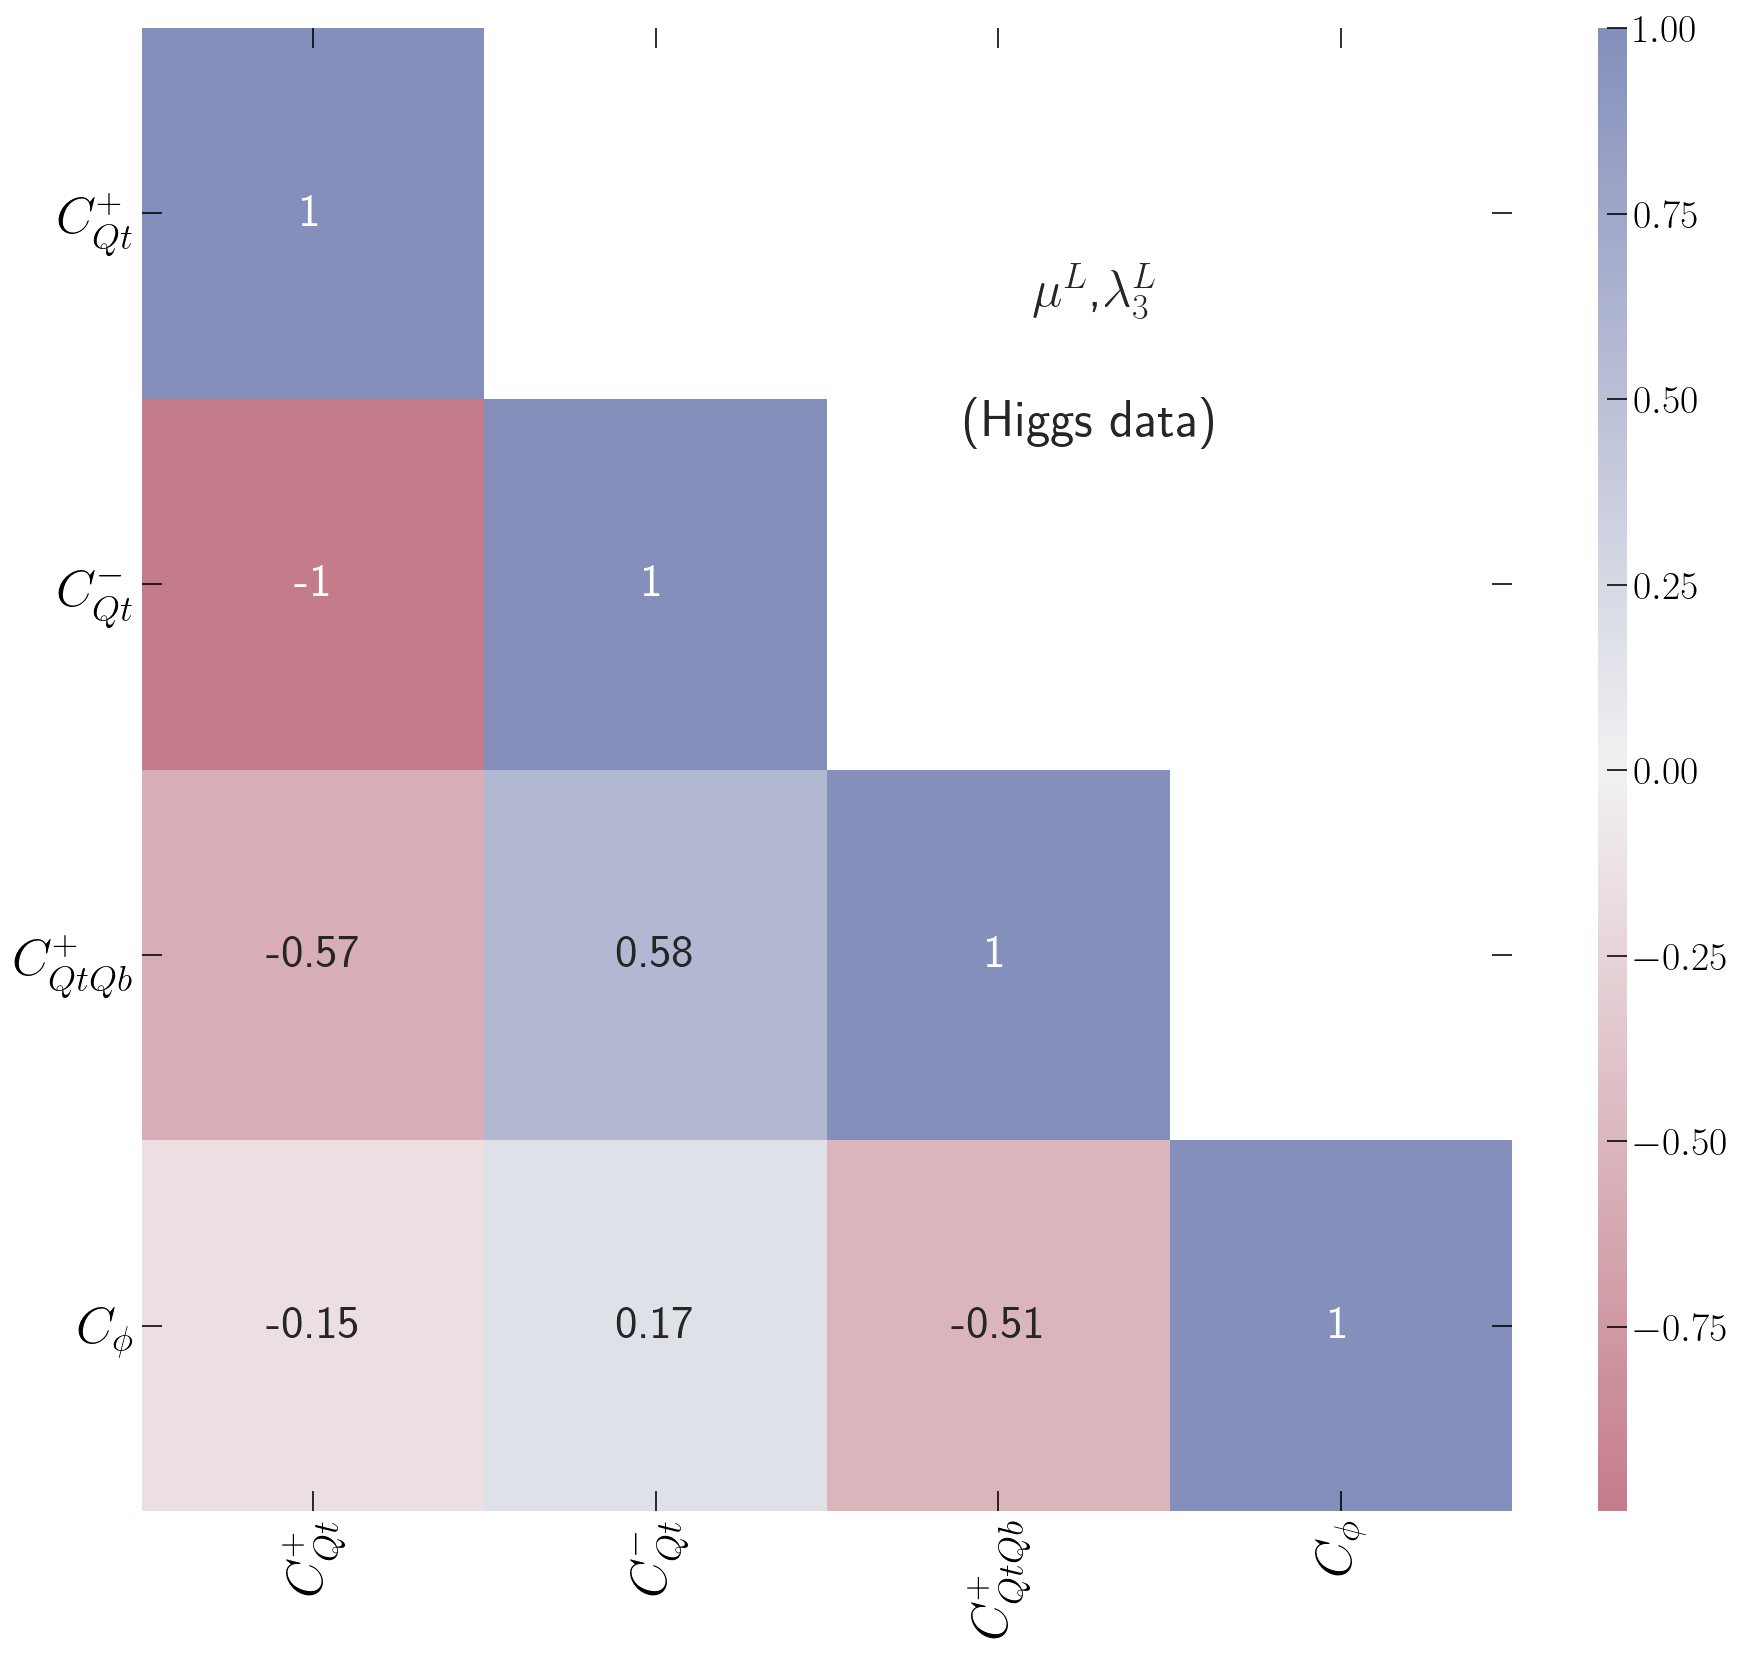

In [21]:
fig, ax = plt.subplots(figsize=(13.5, 12))
cmap = sns.diverging_palette(0,259,s=38,l=60, as_cmap=True)
mask = np.zeros((fit4linear.shape[1],fit4linear.shape[1]))
mask[np.triu_indices_from(mask)] = True
np.fill_diagonal(mask,0)
heat = sns.heatmap(fit4linear+0., mask=mask, annot=True, cmap=cmap, cbar_kws={"aspect": 50}, xticklabels=var, yticklabels=var,
                   annot_kws={"fontsize": 24})
ax = plt.gca()
sns.set(font_scale=2., style='ticks')
plt.text(2.6,.75,r"$\mu^L$,$\lambda_3^L$",fontsize=26)
plt.text(2.4,1.1,r"(Higgs data)",fontsize=26)
heat.set_xticklabels(heat.get_xmajorticklabels(), fontsize = 26, rotation=90)
heat.set_yticklabels(heat.get_ymajorticklabels(), fontsize = 26, rotation=0)
plt.tight_layout()
fig.savefig('../results/plots/4param_corr.pdf', dpi=300)

<ValueView Cqup=-11.865653278637163 Cqum=10.869027751078487 Cquqbp=1.8924874260672686 CH=-7.3963776776588>
<ErrorView Cqup=20.304937526073818 Cqum=17.52043484311348 Cquqbp=2.9766122063308624 CH=19.086511284179895>
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Cqup   │    -12    │    20     │            │            │         │         │       │
│ 1 │ Cqum   │    11     │    17     │            │            │         │         │       │
│ 2 │ Cquqbp │    1.9    │    3.0    │            │            │         │         │       │
│ 3 │ CH     │    -7     │    19     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
            Cqup     Cqum    Cquqbp       

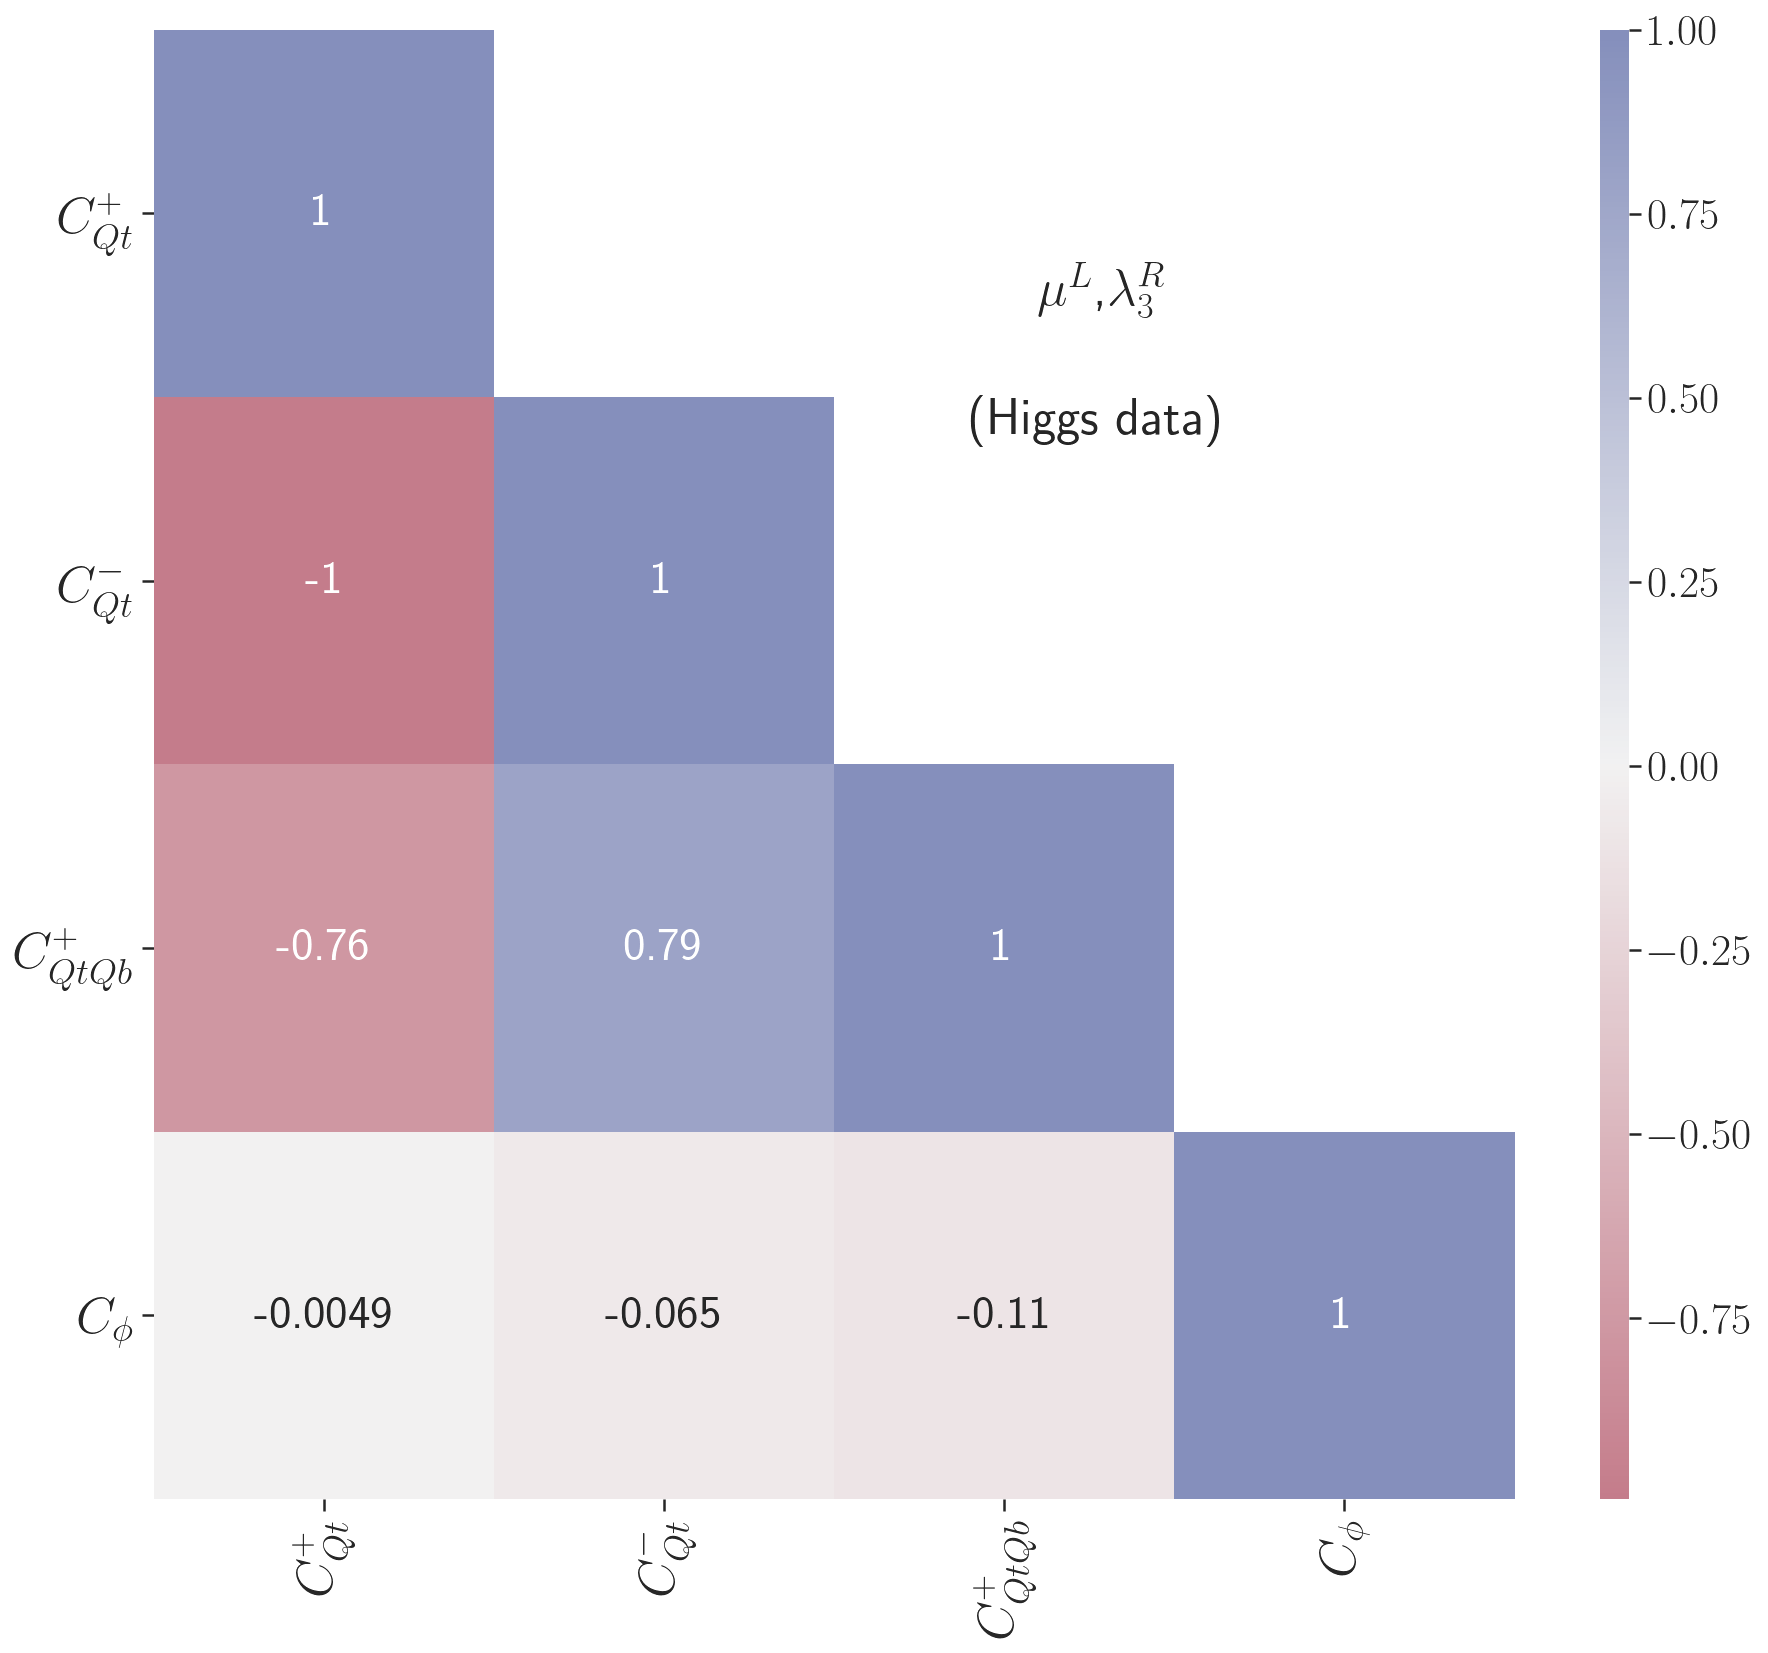

In [23]:
llCqtmchi2 =lambda Cqup,Cqum,Cquqbp,CH :-1/2*mylikelihoodAV(1/2*(Cqup+Cqum),1/2/CF*(Cqup-Cqum),
                                                   1/2/(2*Nc+1)*Cquqbp,+1/CF*Cquqbp/2,CH,data,experiments=['CMS','ATLAS'],
                                                                           HiggsChannels=['ggf','vbf','ttxh','vh','zh','wh']
                                                                           ,TopChannels=None, linearl3=False,linearmu=True)

fit4linear = fit4(llCqtmchi2)
fig, ax = plt.subplots(figsize=(13.5, 12))
cmap = sns.diverging_palette(0,259,s=38,l=60, as_cmap=True)
mask = np.zeros((fit4linear.shape[1],fit4linear.shape[1]))
mask[np.triu_indices_from(mask)] = True
np.fill_diagonal(mask,0)
heat = sns.heatmap(fit4linear+0., mask=mask, annot=True, cmap=cmap, cbar_kws={"aspect": 50}, xticklabels=var, yticklabels=var,
                   annot_kws={"fontsize": 24})
ax = plt.gca()
sns.set(font_scale=2., style='ticks')
plt.text(2.6,.75,r"$\mu^L$,$\lambda_3^R$",fontsize=26)
plt.text(2.4,1.1,r"(Higgs data)",fontsize=26)
heat.set_xticklabels(heat.get_xmajorticklabels(), fontsize = 26, rotation=90)
heat.set_yticklabels(heat.get_ymajorticklabels(), fontsize = 26, rotation=0)
plt.tight_layout()
fig.savefig('../results/plots/4param_corr_l3_R.pdf', dpi=300)